In [65]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Introduction
---
This project is about looking into the most significant variables for detecting a heart failure.

# Data Introduction
---
This data is from Kaggle: https://www.kaggle.com/datasets/fedesoriano/heart-failure-prediction/data
It contains 12 features:
- 7 qualitative
- 5 quantitative

The target variable is `HeartDisease`:
- 1 means that observation has detected a heart disease
- 0 means that there is no heart disease

We are interested in these variables, with descriptions according to Kaggle Data Card:
- Age: I'm assuming the older someone is, the more likely they'll have a heart disease.
- Sex: Male or female
- ChestPainType: There are 4 different type's of chest pain in this dataset:
  - TA: Typical Angina -
  - ATA: Atypical Angina -
  - NAP: Non-Anginal Pain -
  - ASY: Asymptomatic -
- RestBP: High resting BP might be a sign of a possible heart attack.
- Cholesterol: A cholesterol above a certain threshold might cause a heart attack.
- FastingBS: Fasting blood sugar:
  - 1: if FastingBS > 120
  - 0: Otherwise
- RestingECG: 3 different levels
  - Normal
  - ST: having ST-T wave abnormality (depression)
  - LVH: showing probable or definite left ventricular hypertrophy
- MaxHR: Maximum heart rate achieved
- ExerciseAngina: Exercise-induced angina with 2 outcomes
  - Yes
  - No
- Oldpeak: ST - numeric value measured in depression
- ST_Slope: slope of peak exercise ST segment
  - Up: upsloping
  - Flat: flat
  - Down: downsloping

In [66]:
# import libraries
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [67]:
# import data with polars
path = "/content/drive/MyDrive/Data/heart.xls"
df = pl.read_csv(path)
df.head()

Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
i64,str,str,i64,i64,i64,str,i64,str,f64,str,i64
40,"""M""","""ATA""",140,289,0,"""Normal""",172,"""N""",0.0,"""Up""",0
49,"""F""","""NAP""",160,180,0,"""Normal""",156,"""N""",1.0,"""Flat""",1
37,"""M""","""ATA""",130,283,0,"""ST""",98,"""N""",0.0,"""Up""",0
48,"""F""","""ASY""",138,214,0,"""Normal""",108,"""Y""",1.5,"""Flat""",1
54,"""M""","""NAP""",150,195,0,"""Normal""",122,"""N""",0.0,"""Up""",0


In [68]:
df["RestingECG"].value_counts()

RestingECG,count
str,u32
"""Normal""",552
"""LVH""",188
"""ST""",178


# Data Information
---

In [69]:
df.glimpse()

Rows: 918
Columns: 12
$ Age            <i64> 40, 49, 37, 48, 54, 39, 45, 54, 37, 48
$ Sex            <str> 'M', 'F', 'M', 'F', 'M', 'M', 'F', 'M', 'M', 'F'
$ ChestPainType  <str> 'ATA', 'NAP', 'ATA', 'ASY', 'NAP', 'NAP', 'ATA', 'ATA', 'ASY', 'ATA'
$ RestingBP      <i64> 140, 160, 130, 138, 150, 120, 130, 110, 140, 120
$ Cholesterol    <i64> 289, 180, 283, 214, 195, 339, 237, 208, 207, 284
$ FastingBS      <i64> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0
$ RestingECG     <str> 'Normal', 'Normal', 'ST', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal'
$ MaxHR          <i64> 172, 156, 98, 108, 122, 170, 170, 142, 130, 120
$ ExerciseAngina <str> 'N', 'N', 'N', 'Y', 'N', 'N', 'N', 'N', 'Y', 'N'
$ Oldpeak        <f64> 0.0, 1.0, 0.0, 1.5, 0.0, 0.0, 0.0, 0.0, 1.5, 0.0
$ ST_Slope       <str> 'Up', 'Flat', 'Up', 'Flat', 'Up', 'Up', 'Up', 'Up', 'Flat', 'Up'
$ HeartDisease   <i64> 0, 1, 0, 1, 0, 0, 0, 0, 1, 0



In [70]:
df.describe()

statistic,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
str,f64,str,str,f64,f64,f64,str,f64,str,f64,str,f64
"""count""",918.0,"""918""","""918""",918.0,918.0,918.0,"""918""",918.0,"""918""",918.0,"""918""",918.0
"""null_count""",0.0,"""0""","""0""",0.0,0.0,0.0,"""0""",0.0,"""0""",0.0,"""0""",0.0
"""mean""",53.510893,null,null,132.396514,198.799564,0.233115,null,136.809368,null,0.887364,null,0.553377
"""std""",9.432617,null,null,18.514154,109.384145,0.423046,null,25.460334,null,1.06657,null,0.497414
"""min""",28.0,"""F""","""ASY""",0.0,0.0,0.0,"""LVH""",60.0,"""N""",-2.6,"""Down""",0.0
"""25%""",47.0,null,null,120.0,173.0,0.0,null,120.0,null,0.0,null,0.0
"""50%""",54.0,null,null,130.0,223.0,0.0,null,138.0,null,0.6,null,1.0
"""75%""",60.0,null,null,140.0,267.0,0.0,null,156.0,null,1.5,null,1.0
"""max""",77.0,"""M""","""TA""",200.0,603.0,1.0,"""ST""",202.0,"""Y""",6.2,"""Up""",1.0


In [71]:
df.null_count()

Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32
0,0,0,0,0,0,0,0,0,0,0,0


# Data Visualization
---
We want to check if there is a class imbalance with countplots. We also want to check the numerical features and see if there's any outliers. I also want to just split the categorical features and the numerical features, so that it's easier to work. I'm also going to turn `Age`, `RestingBP`, `Cholesterol`, and, `MaxHR` to Float's and keep the integer types as integers because they are encoded categorical variables.

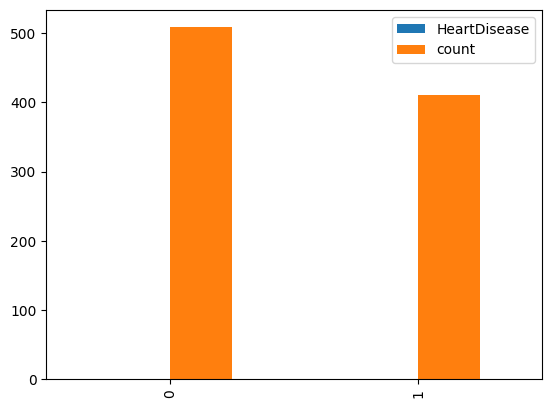

In [72]:
# class imbalance
df["HeartDisease"].value_counts().to_pandas().plot(kind="bar")
plt.show()

- So there is a bit of a class imbalance, and we wil use SMOTE later for "over-sampling" so the classes can be equal.

In [73]:
# convert Age, RestingBP, Cholesterol, and MaxHR to floats and qualitative strings and ints to categorical
df = df.with_columns(
    pl.col("Age").cast(pl.Float64),
    pl.col("RestingBP").cast(pl.Float64),
    pl.col("Cholesterol").cast(pl.Float64),
    pl.col("MaxHR").cast(pl.Float64),
    pl.col("FastingBS").cast(pl.Utf8).cast(pl.Categorical),
    pl.col("Sex").cast(pl.Utf8).cast(pl.Categorical),
    pl.col("ChestPainType").cast(pl.Utf8).cast(pl.Categorical),
    pl.col("RestingECG").cast(pl.Utf8).cast(pl.Categorical),
    pl.col("ExerciseAngina").cast(pl.Utf8).cast(pl.Categorical),
    pl.col("ST_Slope").cast(pl.Utf8).cast(pl.Categorical),
    pl.col("HeartDisease").cast(pl.Utf8).cast(pl.Categorical)
)
df.glimpse()

Rows: 918
Columns: 12
$ Age            <f64> 40.0, 49.0, 37.0, 48.0, 54.0, 39.0, 45.0, 54.0, 37.0, 48.0
$ Sex            <cat> M, F, M, F, M, M, F, M, M, F
$ ChestPainType  <cat> ATA, NAP, ATA, ASY, NAP, NAP, ATA, ATA, ASY, ATA
$ RestingBP      <f64> 140.0, 160.0, 130.0, 138.0, 150.0, 120.0, 130.0, 110.0, 140.0, 120.0
$ Cholesterol    <f64> 289.0, 180.0, 283.0, 214.0, 195.0, 339.0, 237.0, 208.0, 207.0, 284.0
$ FastingBS      <cat> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0
$ RestingECG     <cat> Normal, Normal, ST, Normal, Normal, Normal, Normal, Normal, Normal, Normal
$ MaxHR          <f64> 172.0, 156.0, 98.0, 108.0, 122.0, 170.0, 170.0, 142.0, 130.0, 120.0
$ ExerciseAngina <cat> N, N, N, Y, N, N, N, N, Y, N
$ Oldpeak        <f64> 0.0, 1.0, 0.0, 1.5, 0.0, 0.0, 0.0, 0.0, 1.5, 0.0
$ ST_Slope       <cat> Up, Flat, Up, Flat, Up, Up, Up, Up, Flat, Up
$ HeartDisease   <cat> 0, 1, 0, 1, 0, 0, 0, 0, 1, 0



In [74]:
num_vars = df.select([col for col in df.columns if df[col].dtype == pl.Float64])
cat_vars = df.select([col for col in df.columns if df[col].dtype == pl.Categorical ])
num_vars, cat_vars

(shape: (918, 5)
 ┌──────┬───────────┬─────────────┬───────┬─────────┐
 │ Age  ┆ RestingBP ┆ Cholesterol ┆ MaxHR ┆ Oldpeak │
 │ ---  ┆ ---       ┆ ---         ┆ ---   ┆ ---     │
 │ f64  ┆ f64       ┆ f64         ┆ f64   ┆ f64     │
 ╞══════╪═══════════╪═════════════╪═══════╪═════════╡
 │ 40.0 ┆ 140.0     ┆ 289.0       ┆ 172.0 ┆ 0.0     │
 │ 49.0 ┆ 160.0     ┆ 180.0       ┆ 156.0 ┆ 1.0     │
 │ 37.0 ┆ 130.0     ┆ 283.0       ┆ 98.0  ┆ 0.0     │
 │ 48.0 ┆ 138.0     ┆ 214.0       ┆ 108.0 ┆ 1.5     │
 │ 54.0 ┆ 150.0     ┆ 195.0       ┆ 122.0 ┆ 0.0     │
 │ …    ┆ …         ┆ …           ┆ …     ┆ …       │
 │ 45.0 ┆ 110.0     ┆ 264.0       ┆ 132.0 ┆ 1.2     │
 │ 68.0 ┆ 144.0     ┆ 193.0       ┆ 141.0 ┆ 3.4     │
 │ 57.0 ┆ 130.0     ┆ 131.0       ┆ 115.0 ┆ 1.2     │
 │ 57.0 ┆ 130.0     ┆ 236.0       ┆ 174.0 ┆ 0.0     │
 │ 38.0 ┆ 138.0     ┆ 175.0       ┆ 173.0 ┆ 0.0     │
 └──────┴───────────┴─────────────┴───────┴─────────┘,
 shape: (918, 7)
 ┌─────┬───────────────┬───────────┬───────────

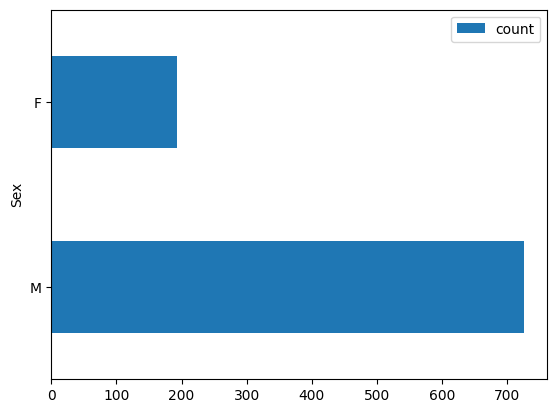

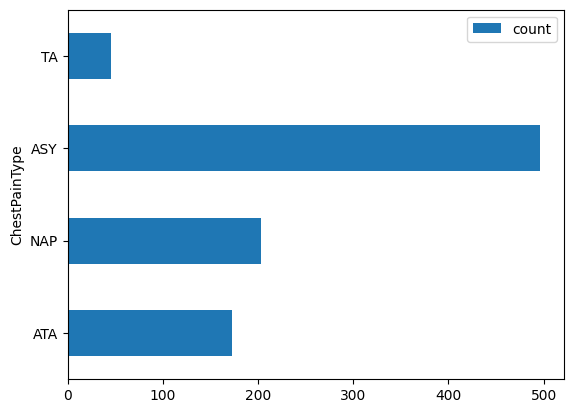

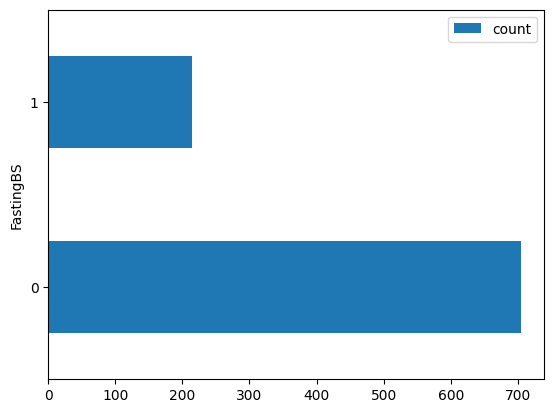

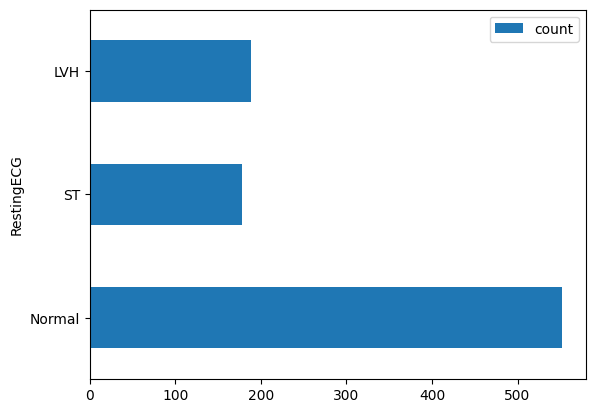

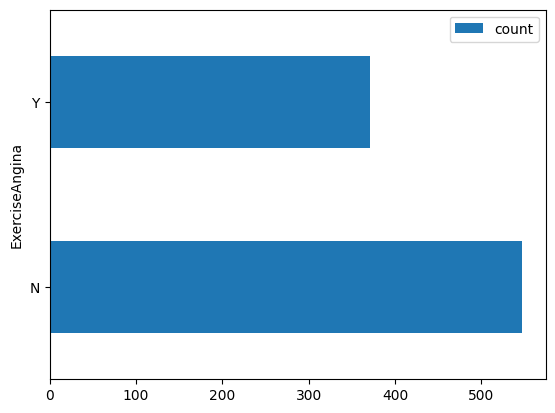

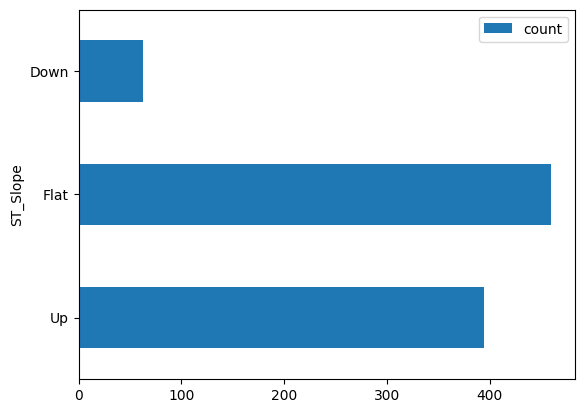

In [75]:
for col in cat_vars.columns:
  if col != "HeartDisease":
    df[col].value_counts().to_pandas().plot(kind='barh', x=col, y="count")
    plt.ylabel(col)
    plt.show()

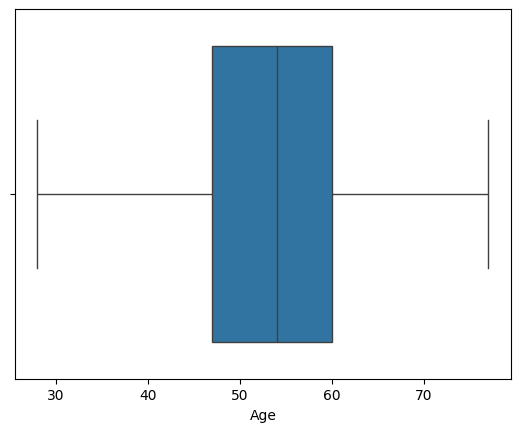

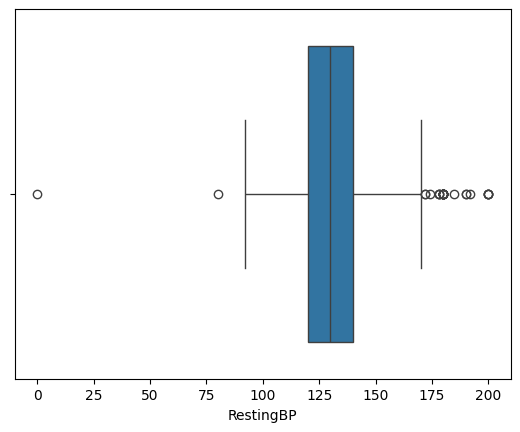

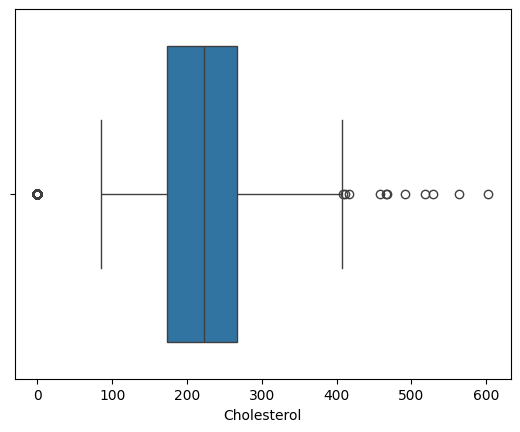

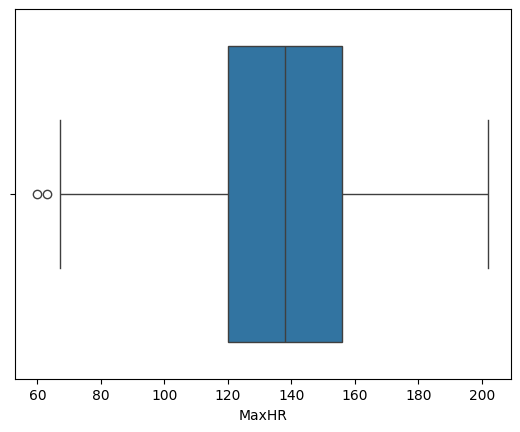

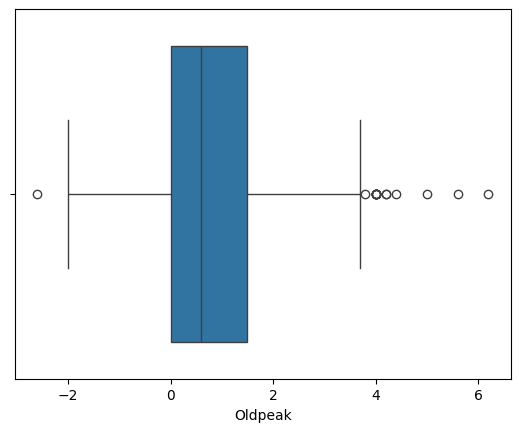

In [76]:
for col in num_vars:
  sns.boxplot(data=df, x=col)
  plt.show()

Let's see what the outliers look like using IQR threshold method. I think we should keep in mind that outliers for variables like cholesterol might serve a purpose. Really high cholesterol is surely going to cause some problems that need to be looked at. Also, if we look, there is a Resting BP at basically 0, which is probably not very good. It looks like we will remove the outliers that are on the left side/below the lower bound.  

In [77]:
# IQR threshold method
def outlier_iqr(df, col):
  q1 = df[col].quantile(0.25)
  q3 = df[col].quantile(0.75)
  iqr = q3 - q1
  lower_bound = q1 - 1.5 * iqr
  upper_bound = q3 + 1.5 * iqr
  filter_series = pl.Series(df.select([pl.col(col).is_between(lower_bound, upper_bound)]))
  return filter_series

In [78]:
for col in num_vars.columns:
  print(outlier_iqr(df, col).value_counts())

shape: (1, 2)
┌──────┬───────┐
│ Age  ┆ count │
│ ---  ┆ ---   │
│ bool ┆ u32   │
╞══════╪═══════╡
│ true ┆ 918   │
└──────┴───────┘
shape: (2, 2)
┌───────────┬───────┐
│ RestingBP ┆ count │
│ ---       ┆ ---   │
│ bool      ┆ u32   │
╞═══════════╪═══════╡
│ false     ┆ 28    │
│ true      ┆ 890   │
└───────────┴───────┘
shape: (2, 2)
┌─────────────┬───────┐
│ Cholesterol ┆ count │
│ ---         ┆ ---   │
│ bool        ┆ u32   │
╞═════════════╪═══════╡
│ false       ┆ 183   │
│ true        ┆ 735   │
└─────────────┴───────┘
shape: (2, 2)
┌───────┬───────┐
│ MaxHR ┆ count │
│ ---   ┆ ---   │
│ bool  ┆ u32   │
╞═══════╪═══════╡
│ false ┆ 2     │
│ true  ┆ 916   │
└───────┴───────┘
shape: (2, 2)
┌─────────┬───────┐
│ Oldpeak ┆ count │
│ ---     ┆ ---   │
│ bool    ┆ u32   │
╞═════════╪═══════╡
│ false   ┆ 16    │
│ true    ┆ 902   │
└─────────┴───────┘


In [79]:
# make function that removes lower bound outliers

In [80]:
# remove the outliers below the lower bound but keep the upper bound outliers
for col in num_vars.columns:
  df = df.filter(outlier_iqr(df, col))
  print(df.select([pl.col(col)]).describe())

shape: (9, 2)
┌────────────┬───────────┐
│ statistic  ┆ Age       │
│ ---        ┆ ---       │
│ str        ┆ f64       │
╞════════════╪═══════════╡
│ count      ┆ 918.0     │
│ null_count ┆ 0.0       │
│ mean       ┆ 53.510893 │
│ std        ┆ 9.432617  │
│ min        ┆ 28.0      │
│ 25%        ┆ 47.0      │
│ 50%        ┆ 54.0      │
│ 75%        ┆ 60.0      │
│ max        ┆ 77.0      │
└────────────┴───────────┘
shape: (9, 2)
┌────────────┬────────────┐
│ statistic  ┆ RestingBP  │
│ ---        ┆ ---        │
│ str        ┆ f64        │
╞════════════╪════════════╡
│ count      ┆ 890.0      │
│ null_count ┆ 0.0        │
│ mean       ┆ 131.113483 │
│ std        ┆ 15.839732  │
│ min        ┆ 92.0       │
│ 25%        ┆ 120.0      │
│ 50%        ┆ 130.0      │
│ 75%        ┆ 140.0      │
│ max        ┆ 170.0      │
└────────────┴────────────┘
shape: (9, 2)
┌────────────┬─────────────┐
│ statistic  ┆ Cholesterol │
│ ---        ┆ ---         │
│ str        ┆ f64         │
╞════════════╪═══

# Preprocessing Data
---
The first thing we will do is drop Customer ID because it provides no value to the dataset, and will not help with predictions/modeling.

In [81]:
# get dummy variables and drop the first dummy variable of each variable group because the other variables in each variable group will be 0
df_dummies = pl.concat([df.select(num_vars), df.select(cat_vars).to_dummies(drop_first=True)], how="horizontal")

In [82]:
df_dummies.head()

Age,RestingBP,Cholesterol,MaxHR,Oldpeak,Sex_F,ChestPainType_ASY,ChestPainType_NAP,ChestPainType_TA,FastingBS_1,RestingECG_LVH,RestingECG_ST,ExerciseAngina_Y,ST_Slope_Down,ST_Slope_Flat,HeartDisease_1
f64,f64,f64,f64,f64,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8
40.0,140.0,289.0,172.0,0.0,0,0,0,0,0,0,0,0,0,0,0
49.0,160.0,180.0,156.0,1.0,1,0,1,0,0,0,0,0,0,1,1
37.0,130.0,283.0,98.0,0.0,0,0,0,0,0,0,1,0,0,0,0
48.0,138.0,214.0,108.0,1.5,1,1,0,0,0,0,0,1,0,1,1
54.0,150.0,195.0,122.0,0.0,0,0,1,0,0,0,0,0,0,0,0


In [83]:
# create features and target variable
X = df_dummies.drop("HeartDisease_1")
y = df_dummies["HeartDisease_1"]

In [84]:
# split data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [85]:
# fix imbalancing
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train.to_numpy(), y_train.to_numpy())

In [86]:
pl.Series(y_train_resampled).value_counts(), y_train_resampled.shape

(shape: (2, 2)
 ┌─────┬───────┐
 │     ┆ count │
 │ --- ┆ ---   │
 │ u8  ┆ u32   │
 ╞═════╪═══════╡
 │ 1   ┆ 401   │
 │ 0   ┆ 401   │
 └─────┴───────┘,
 (802,))

In [87]:
X_train_resampled.shape

(802, 15)

# Modeling
---
We will use Logistic Regression, LightGBM, XGBoost, and KNN. We will compare the metrics on each and then build a final model afterwards. The optuna library will be used to tune hyperparameters.

In [88]:
!pip install optuna

In [89]:
import optuna
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

In [90]:
models = {
    "Logistic Regression": LogisticRegression(),
    "LightGBM": LGBMClassifier(),
    "XGBoost": XGBClassifier(),
    "KNN": KNeighborsClassifier()
}

In [91]:
# create objective function for optuna
def objective(trial, model_name):
    if model_name == "Logistic Regression":
        # Define hyperparameters to tune for Logistic Regression
        logreg_c = trial.suggest_float("C", 1e-5, 1e5, log=True)
        logreg_solver = trial.suggest_categorical("solver", ["liblinear", "lbfgs"])
        model = LogisticRegression(C=logreg_c, solver=logreg_solver, random_state=42)

    elif model_name == "LightGBM":
        # Define hyperparameters to tune for LightGBM
        lgbm_n_estimators = trial.suggest_int("n_estimators", 50, 1000)
        lgbm_learning_rate = trial.suggest_float("learning_rate", 1e-5, 0.1, log=True)
        lgbm_num_leaves = trial.suggest_int("num_leaves", 2, 256)
        lgbm_max_depth = trial.suggest_int("max_depth", -1, 50)
        lgbm_min_child_samples = trial.suggest_int("min_child_samples", 5, 100)
        model = LGBMClassifier(n_estimators=lgbm_n_estimators, learning_rate=lgbm_learning_rate,
                               num_leaves=lgbm_num_leaves, max_depth=lgbm_max_depth,
                               min_child_samples=lgbm_min_child_samples, random_state=42)

    elif model_name == "XGBoost":
        # Define hyperparameters to tune for XGBoost
        xgb_n_estimators = trial.suggest_int("n_estimators", 50, 1000)
        xgb_learning_rate = trial.suggest_float("learning_rate", 1e-5, 0.1, log=True)
        xgb_max_depth = trial.suggest_int("max_depth", 3, 10)
        xgb_min_child_weight = trial.suggest_int("min_child_weight", 1, 10)
        xgb_gamma = trial.suggest_float("gamma", 0, 1.0)
        xgb_subsample = trial.suggest_float("subsample", 0.6, 1.0)
        xgb_colsample_bytree = trial.suggest_float("colsample_bytree", 0.6, 1.0)
        model = XGBClassifier(n_estimators=xgb_n_estimators, learning_rate=xgb_learning_rate,
                              max_depth=xgb_max_depth, min_child_weight=xgb_min_child_weight,
                              gamma=xgb_gamma, subsample=xgb_subsample,
                              colsample_bytree=xgb_colsample_bytree, random_state=42)

    elif model_name == "KNN":
        # Define hyperparameters to tune for KNN
        knn_n_neighbors = trial.suggest_int("n_neighbors", 1, 30)
        knn_weights = trial.suggest_categorical("weights", ["uniform", "distance"])
        knn_metric = trial.suggest_categorical("metric", ["euclidean", "manhattan", "minkowski"])
        model = KNeighborsClassifier(n_neighbors=knn_n_neighbors, weights=knn_weights, metric=knn_metric)

    else:
        raise ValueError(f"Model '{model_name}' not supported.")

    # Train the model
    model.fit(X_train_resampled, y_train_resampled)

    # Evaluate the model on the test set
    # Convert X_test to numpy array for prediction consistency
    y_pred = model.predict(X_test.to_numpy())
    roc_auc = roc_auc_score(y_test, y_pred)

    return roc_auc

In [92]:
# create studys
study_logreg = optuna.create_study(direction="maximize")
study_lgbm = optuna.create_study(direction="maximize")
study_xgb = optuna.create_study(direction="maximize")
study_knn = optuna.create_study(direction="maximize")

[I 2025-09-29 15:52:22,816] A new study created in memory with name: no-name-baeec044-058e-4260-ba3f-2ef6b3908333
[I 2025-09-29 15:52:22,820] A new study created in memory with name: no-name-ff75e4af-9502-477a-8499-908ca67420e8
[I 2025-09-29 15:52:22,821] A new study created in memory with name: no-name-ed982b32-99cf-4b40-ae52-43ab3b1ae65e
[I 2025-09-29 15:52:22,823] A new study created in memory with name: no-name-5c1b545c-2a3a-4774-8a25-56244d1b8da5


In [93]:
# create study dictionary for looping
studies = {
    "Logistic Regression": study_logreg,
    # "LightGBM": study_lgbm,
    "XGBoost": study_xgb,
    "KNN": study_knn
}

In [94]:
results = []

for model_name, study in studies.items():
    print(f"Running Optuna study for {model_name}...")
    study.optimize(lambda trial: objective(trial, model_name), n_trials=50) # You can adjust the number of trials
    best_params = study.best_params
    best_roc_auc = study.best_value

    # Train the best model and evaluate on test set to get other metrics
    if model_name == "Logistic Regression":
        best_model = LogisticRegression(**best_params, random_state=42)
    elif model_name == "LightGBM":
        best_model = LGBMClassifier(**best_params, random_state=42)
    elif model_name == "XGBoost":
        best_model = XGBClassifier(**best_params, random_state=42)
    elif model_name == "KNN":
        best_model = KNeighborsClassifier(**best_params)
    else:
        best_model = None # Should not happen with the current models

    if best_model:
        best_model.fit(X_train_resampled, y_train_resampled)
        y_pred = best_model.predict(X_test)

        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        conf_matrix = confusion_matrix(y_test, y_pred)

        results.append({
            "Model": model_name,
            "Best Params": best_params,
            "ROC AUC": best_roc_auc,
            "Accuracy": accuracy,
            "Precision": precision,
            "Recall": recall,
            "F1 Score": f1,
            "Confusion Matrix": conf_matrix.tolist() # Convert to list for easier storage/display
        })

results_df = pl.DataFrame(results)
display(results_df)

[I 2025-09-29 15:52:22,870] Trial 0 finished with value: 0.6515353805073432 and parameters: {'C': 0.0012475136569655963, 'solver': 'liblinear'}. Best is trial 0 with value: 0.6515353805073432.
[I 2025-09-29 15:52:22,887] Trial 1 finished with value: 0.8574462920257312 and parameters: {'C': 2772.470822350113, 'solver': 'liblinear'}. Best is trial 1 with value: 0.8574462920257312.
[I 2025-09-29 15:52:22,903] Trial 2 finished with value: 0.8621191892219929 and parameters: {'C': 0.7104258089546136, 'solver': 'liblinear'}. Best is trial 2 with value: 0.8621191892219929.
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/

Running Optuna study for Logistic Regression...


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
[I 2025-09-29 15:52:23,100] Trial 4 finished with value: 0.8667920864182546 and parameters: {'C': 8.403999919760482, 'solver': 'lbfgs'}. Best is trial 4 with value: 0.8667920864182546.
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/pr

Running Optuna study for XGBoost...


[I 2025-09-29 15:52:31,300] Trial 0 finished with value: 0.8314722660517053 and parameters: {'n_estimators': 551, 'learning_rate': 0.00015380510467310845, 'max_depth': 3, 'min_child_weight': 7, 'gamma': 0.34610905991944263, 'subsample': 0.8299753944340956, 'colsample_bytree': 0.8406114238438324}. Best is trial 0 with value: 0.8314722660517053.
[I 2025-09-29 15:52:37,548] Trial 1 finished with value: 0.8678237650200267 and parameters: {'n_estimators': 438, 'learning_rate': 0.00010533236953255159, 'max_depth': 8, 'min_child_weight': 1, 'gamma': 0.5111202438446026, 'subsample': 0.9381014602960169, 'colsample_bytree': 0.874073690053607}. Best is trial 1 with value: 0.8678237650200267.
[I 2025-09-29 15:52:38,725] Trial 2 finished with value: 0.8444592790387184 and parameters: {'n_estimators': 403, 'learning_rate': 0.002134096259000879, 'max_depth': 3, 'min_child_weight': 6, 'gamma': 0.46809318719688797, 'subsample': 0.9169562749125274, 'colsample_bytree': 0.7974936246156711}. Best is trial 

Running Optuna study for KNN...


[I 2025-09-29 15:53:05,748] Trial 16 finished with value: 0.734373103531982 and parameters: {'n_neighbors': 7, 'weights': 'distance', 'metric': 'manhattan'}. Best is trial 16 with value: 0.734373103531982.
[I 2025-09-29 15:53:05,762] Trial 17 finished with value: 0.7073673989561841 and parameters: {'n_neighbors': 6, 'weights': 'distance', 'metric': 'manhattan'}. Best is trial 16 with value: 0.734373103531982.
[I 2025-09-29 15:53:05,776] Trial 18 finished with value: 0.6619128535016385 and parameters: {'n_neighbors': 3, 'weights': 'uniform', 'metric': 'minkowski'}. Best is trial 16 with value: 0.734373103531982.
[I 2025-09-29 15:53:05,789] Trial 19 finished with value: 0.665554072096128 and parameters: {'n_neighbors': 13, 'weights': 'distance', 'metric': 'euclidean'}. Best is trial 16 with value: 0.734373103531982.
[I 2025-09-29 15:53:05,804] Trial 20 finished with value: 0.7260589877412308 and parameters: {'n_neighbors': 8, 'weights': 'distance', 'metric': 'manhattan'}. Best is trial 1

Model,Best Params,ROC AUC,Accuracy,Precision,Recall,F1 Score,Confusion Matrix
str,struct[12],f64,f64,f64,f64,f64,list[list[i64]]
"""Logistic Regression""","{null,null,null,null,null,null,null,16611.217385,""lbfgs"",null,null,null}",0.871465,0.869565,0.910891,0.859813,0.884615,"[[68, 9], [15, 92]]"
"""XGBoost""","{639,0.006434,5,5,0.117105,0.823955,0.879316,null,null,null,null,null}",0.898471,0.896739,0.931373,0.88785,0.909091,"[[70, 7], [12, 95]]"
"""KNN""","{null,null,null,null,null,null,null,null,null,7,""distance"",""manhattan""}",0.734373,0.722826,0.825581,0.663551,0.735751,"[[62, 15], [36, 71]]"


# Evaluation
---

In [95]:
# Extract best parameters for XGBoost directly from the study object
xgb_best_params = study_xgb.best_params

# Initialize and train the final XGBoost model with the best parameters
final_xgb_model = XGBClassifier(**xgb_best_params, random_state=42)
final_xgb_model.fit(X_train_resampled, y_train_resampled)

# Evaluate the final model on the test set
y_pred_final_xgb = final_xgb_model.predict(X_test.to_numpy())

final_accuracy = accuracy_score(y_test, y_pred_final_xgb)
final_precision = precision_score(y_test, y_pred_final_xgb)
final_recall = recall_score(y_test, y_pred_final_xgb)
final_f1 = f1_score(y_test, y_pred_final_xgb)
final_roc_auc = roc_auc_score(y_test, y_pred_final_xgb)
final_conf_matrix = confusion_matrix(y_test, y_pred_final_xgb)

print("Final XGBoost Model Performance:")
print(f"Accuracy: {final_accuracy:.4f}")
print(f"Precision: {final_precision:.4f}")
print(f"Recall: {final_recall:.4f}")
print(f"F1 Score: {final_f1:.4f}")
print(f"ROC AUC: {final_roc_auc:.4f}")
print("Confusion Matrix:")
print(final_conf_matrix)

Final XGBoost Model Performance:
Accuracy: 0.8967
Precision: 0.9314
Recall: 0.8879
F1 Score: 0.9091
ROC AUC: 0.8985
Confusion Matrix:
[[70  7]
 [12 95]]


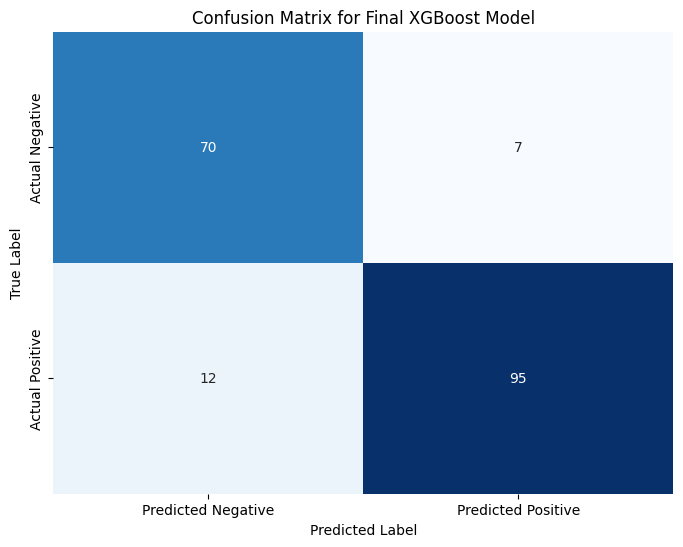

In [96]:
# Visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(final_conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted Negative', 'Predicted Positive'],
            yticklabels=['Actual Negative', 'Actual Positive'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Final XGBoost Model')
plt.show()

Feature Significance (Importance) from XGBoost Model:


Feature,Importance
str,f32
"""ST_Slope_Flat""",0.302388
"""ExerciseAngina_Y""",0.194699
"""ChestPainType_ASY""",0.109592
"""ST_Slope_Down""",0.085591
"""Sex_F""",0.059752
…,…
"""Age""",0.022581
"""RestingBP""",0.02023
"""RestingECG_ST""",0.01906


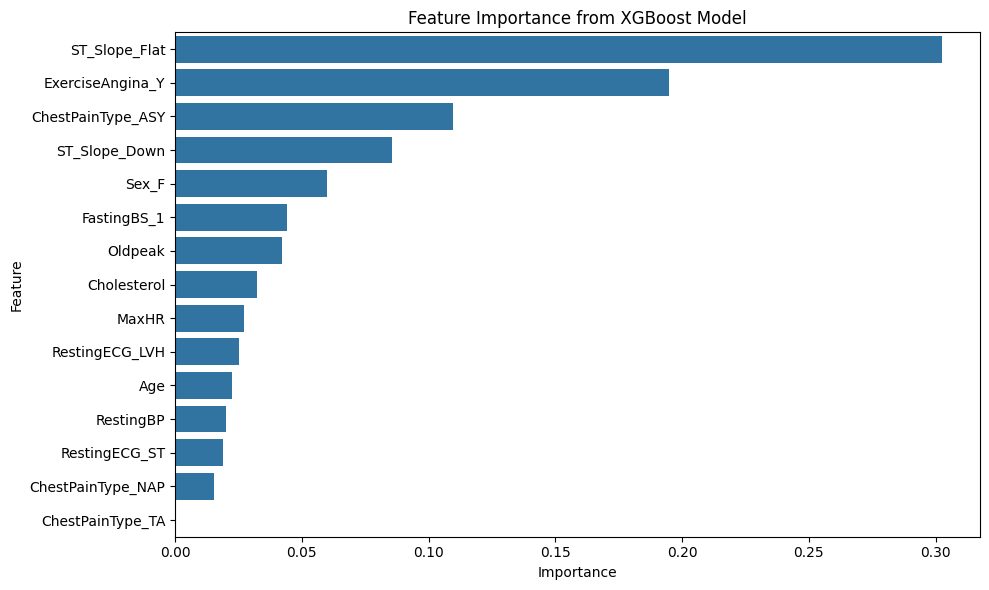

In [97]:
# get feature importances from the trained XGBoost model
feature_importances = final_xgb_model.feature_importances_

# get the feature names from the training data
feature_names = X_train.columns

# create a DataFrame to display feature importance
importance_df = pl.DataFrame({'Feature': feature_names, 'Importance': feature_importances})

# sort the DataFrame by importance in descending order
importance_df = importance_df.sort(by='Importance', descending=True)

# Display the feature importance
print("Feature Significance (Importance) from XGBoost Model:")
display(importance_df)

# Optionally, visualize the feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df.to_pandas()) # Convert to pandas for seaborn plotting
plt.title('Feature Importance from XGBoost Model')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

# What I've Learned
---
We've learned that the top 3 most signifiant variables to detect a possible heart disease issue are when
- the ST slope is flat, which makes sense. The ST slope being flat or flat-lined means that someone is not living anymore or at least the heart is not pumping anymore;
- Exercise angina or pain that occurs during a physical activity is a common sign of heart disease;
- And asymptomatic angina for chest pain type is also a significant sign for heart disease, which is a condition where your heart muscle doesn't get enough oxygen due to narrowed or even blocked coronary arteries, but the individual doesn't really experience the chest pain or other warnings that it's actually blocked.  

# Impact
---
Detecting variables for heart disease is very impactful because it could literally save someones life, depending on the time these variables were recorded. It would be cool to see certain patients who've gotten diagnosed sooner so we can prioiritize which variables need to be taken care of first or if we can treat multiple variables at the same time. It would also be cool to see if two or more variables together cause something else, which I think is called interaction terms.

# References
---
Kaggle Dataset: https://www.kaggle.com/datasets/fedesoriano/heart-failure-prediction

In [98]:
from pathlib import Path
focus_path = Path("/content/drive/MyDrive/Colab Notebooks/Heart Disease.ipynb")

In [99]:
!jupyter nbconvert --to html "{focus_path}"

[NbConvertApp] Converting notebook /content/drive/MyDrive/Colab Notebooks/Heart Disease.ipynb to html
[NbConvertApp] WARNING | Alternative text is missing on 12 image(s).
[NbConvertApp] Writing 505803 bytes to /content/drive/MyDrive/Colab Notebooks/Heart Disease.html
